# Intended to replace load_and_process

# given one image id, pull it down, then show the outline of buildings

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import json

import sys
sys.path.append("D:\\projects\\geo_image_experiments\\src")
import importlib
import mapillary_utils as mu
importlib.reload(mu)
import image_processing_utils as ipu
importlib.reload(ipu)
import detection_analysis_utils as dau
importlib.reload(dau)

import re

from dotenv import load_dotenv
from os import getenv

from PIL import Image


from matplotlib.path import Path

import matplotlib.pyplot as plt

In [2]:
load_dotenv()
API_KEY = getenv("MAPILLARY_CLIENT_TOKEN")
api_key = API_KEY

In [6]:


image_id = '1068419173817547'
#image_id = '2379488058858289'
image_id = '1096900881355625'
image_path = f"c:\\temp\\mapillary_{image_id}.jpg"
image_path


'c:\\temp\\mapillary_1096900881355625.jpg'

In [7]:
image, metadata = mu.get_mapillary_image(image_id, api_key, image_size_indicator='thumb_2048_url', image_dir="c:\\temp")

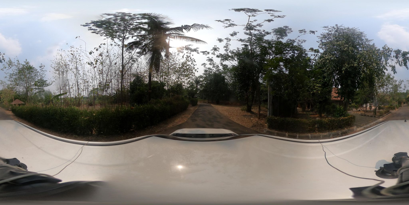

In [8]:
ipu.get_thumbnail(image)

In [9]:
detections = mu.get_mapillary_detections(image_id, api_key)
df_detections = mu.extract_detections(detections)

arrays = df_detections.apply(lambda x: mu.decode_base64_geometry_fromdf(x, normalize=True, image_height=metadata['height'],\
                                                                                         image_width=metadata['width']), axis=1)

temp_df = [pd.DataFrame(arr, columns=['image_id', 'detection_id','detection_label','feature_id', 'image_height', 'image_width', 'extent','properties','coordinates']) for arr in arrays]
df_detection_coords = pd.concat(temp_df, ignore_index=True)

In [10]:
set(df_detection_coords.detection_label.tolist())


{'construction--barrier--curb',
 'construction--flat--driveway',
 'construction--flat--road',
 'construction--structure--building',
 'nature--sky',
 'nature--vegetation',
 'object--support--pole',
 'object--support--utility-pole',
 'object--vehicle--motorcycle',
 'void--ego-vehicle',
 'void--ground',
 'void--static',
 'void--unlabeled'}

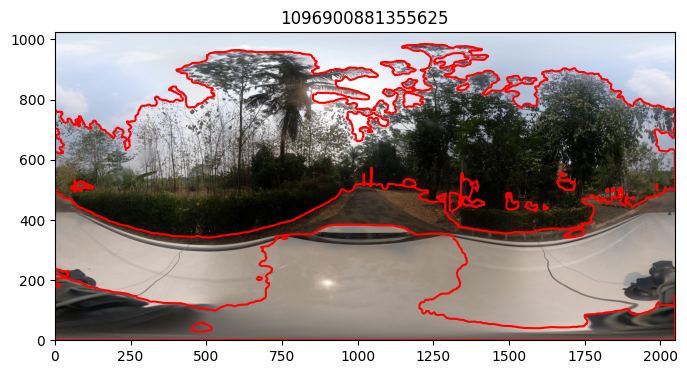

In [16]:
selected_labels = ['construction--structure--building','void--ego-vehicle','nature--vegetation']
fig = dau.draw_polygons(df_detection_coords[df_detection_coords.detection_label.isin(selected_labels)].coordinates.tolist(),\
                             max_x=image.size[0], max_y=image.size[1], display='outline', image_underlay=image, color='red', title=metadata['image_id'])
fig

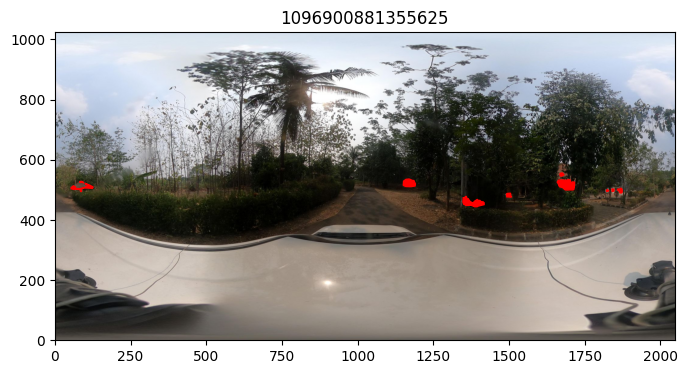

In [13]:
selected_label = 'construction--structure--building'

fig = dau.draw_polygons(df_detection_coords[df_detection_coords.detection_label == selected_label].coordinates.tolist(),\
                             max_x=image.size[0], max_y=image.size[1], display='fill', image_underlay=image, color='red', title=metadata['image_id'])
fig


# Get Percent Pixels

In [36]:

df_detection_coords['relative_pixel_count'] = df_detection_coords.coordinates.apply(dau.detect_relative_pixel_count)


In [37]:
df_detection_coords.sort_values(by='relative_pixel_count', ascending=False)

,image_id,detection_id,detection_label,feature_id,image_height,image_width,extent,properties,coordinates,relative_pixel_count
281,187941237651945,188143407631728,nature--vegetation,1,1024,2048,4096,{},"[[0, 1024], [1983, 1024], [1983, 1022], [1989,...",367
73,187941237651945,188142870965115,construction--flat--road,1,1024,2048,4096,{},"[[0, 482], [7, 484], [12, 491], [18, 493], [19...",343
241,187941237651945,188143294298406,nature--sky,1,1024,2048,4096,{},"[[581, 589], [579, 590], [579, 598], [582, 605...",201
323,187941237651945,188143454298390,void--ego-vehicle,1,1024,2048,4096,{},"[[0, 359], [6, 359], [9, 365], [7, 375], [12, ...",194
408,187941237651945,188143704298365,void--unlabeled,1,1024,2048,4096,{},"[[1118, 149], [1119, 152], [1121, 153], [1121,...",166
...,...,...,...,...,...,...,...,...,...,...
233,187941237651945,188143270965075,nature--sky,1,1024,2048,4096,{},"[[743, 561], [744, 557], [743, 557], [743, 561]]",0
234,187941237651945,188143274298408,nature--sky,1,1024,2048,4096,{},"[[742, 565], [743, 561], [742, 561], [742, 563...",0
235,187941237651945,188143277631741,nature--sky,1,1024,2048,4096,{},"[[64, 538], [58, 539], [55, 536], [51, 535], [...",0
236,187941237651945,188143280965074,nature--sky,1,1024,2048,4096,{},"[[1983, 1024], [2032, 1024], [2032, 1022], [20...",0


In [39]:
df_detections = df_detection_coords.groupby(['image_id','detection_label'], as_index=False)['relative_pixel_count'].sum()
df_detections = df_detection_coords.groupby(['image_id','detection_label'])['relative_pixel_count'].sum() / df_detection_coords.groupby('image_id')['relative_pixel_count'].sum() * 100
df_detections = df_detections.reset_index(name='percent_of_image')
df_detections.sort_values(by='percent_of_image', ascending=False)[0:10]

#detections that START WITH these strings will be ignored
detection_stop_class = ['regulatory','marking','warning','complementary','object--traffic-sign']
#detections consuming less than n% will be dropped
detection_prct_threshold = 2 


,image_id,detection_label,percent_of_image
3,187941237651945,construction--flat--road,20.105062
12,187941237651945,nature--vegetation,18.242598
25,187941237651945,void--unlabeled,13.801337
23,187941237651945,void--ego-vehicle,11.365807
10,187941237651945,nature--sky,9.598854
5,187941237651945,construction--structure--building,5.826170
16,187941237651945,object--support--pole,4.918816
8,187941237651945,marking--continuous--solid,2.483286
0,187941237651945,construction--barrier--curb,2.387775
4,187941237651945,construction--flat--sidewalk,2.387775


In [76]:
def filter_detections(detection_label, stop_list=[]):
    """
    indicate which detections should be filtered out

    Parameters:
    -detection_label: mapillary detection label
    -stop_list: list of detection fragments from the beginning. Code will 
        do a pattern match from beginning of string

    Returns:
    - True: to indicate detection should be filtered
    - False: to indicate the detection should be kept
    """

    if len(stop_list) == 0:
        stop_detection_list = ['regulatory','marking','warning','complementary','object--traffic-sign']
    else:
        stop_detection_list = stop_list

    for stop_detection in stop_detection_list:
        if re.match(stop_detection,detection_label):
            return True

    return False


df_detections['filter_out'] = df_detections.detection_label.apply(dau.filter_detections)

In [78]:
df_detections[df_detections['filter_out'] == False].shape

(686, 5)

## end

In [243]:
import numpy as np
from shapely.geometry import Polygon
import matplotlib.path as mplPath




def zz_detect_pixel_count(coords, step_down=0.01):

    #shrink coords by step_down prct
    small_coords = []
    for c in coords:
        small_coords.append( [ int(c[0] * step_down) , int(c[1] * step_down)] )
        

    polygon = Polygon(small_coords)

    # Step 2: Create a grid of points covering the bounding box of the polygon
    min_x, min_y, max_x, max_y = polygon.bounds
    
    #min_x = min_x * step_down
    #min_y = min_y * step_down
    #max_x = max_x * step_down
    #max_y = max_y * step_down
    
    x = np.arange(min_x, max_x + 1)
    y = np.arange(min_y, max_y + 1)
    xx, yy = np.meshgrid(x, y)
    points = np.c_[xx.ravel(), yy.ravel()]
    
    # Step 3: Check which points lie within the polygon
    path = mplPath.Path(small_coords)
    mask = path.contains_points(small_coords)
    
    # Step 4: Count the number of pixels (points) within the polygon
    num_pixels_within_polygon = np.sum(mask)
    return num_pixels_within_polygon
    #print(f'Number of pixels within the polygon: {num_pixels_within_polygon}')




In [46]:
def zz_draw_polygons(polygons,  max_x=2200, max_y=1200, display='fill', image_underlay=None, color='green', title=None):
    """
    Draws polygons on top of a background image.

    Parameters:
    - polygons: List of polygons to draw (list of (x, y) coordinates).
    - image_path: Path to the background image.
    - max_x: Maximum x-axis size.
    - max_y: Maximum y-axis size.
    - display: 'fill' or 'outline' to specify whether to fill or outline polygons.
    - image_underlay: pass in the image if you want to see the results on top of the image.
    - color: Color for the polygon.
    - title: passing in the file name is often helpful.

    Returns:
    - normalized_polygon: Normalized polygons (currently not used).
    """

    polygons_for_chart = []
    
    for polygon in polygons:
        w = []
        y = []
        for xy in polygon:

            w.append(xy[0])
            y.append(xy[1])
        polygons_for_chart.append([w,y])


    #set x figsize, then proportionately set y
    fig_x = 8
    fig_y = int(max_y / (max_x / fig_x))
    fig, ax = plt.subplots(figsize=(fig_x, fig_y))  

    if image_underlay is not None:
        ax.imshow(image_underlay, extent=[0, max_x, 0, max_y], aspect='auto')
    
    for shape in polygons_for_chart:
        if display == 'outline':
            ax.plot(shape[0], shape[1], marker='', markersize=1, color=color)
        elif display == 'fill':
            ax.fill(shape[0], shape[1], color=color)     
        else:
            ax.fill(shape[0], shape[1], color=color)


    ax.set_xlim(0, max_x)
    ax.set_ylim(0, max_y)
    
    # Force the two axes to intersect at 0
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')

    # Adding title and labels
    plt.title(title)
    #plt.xlabel('w')
    #plt.ylabel('y')

    #prevent Jupyter from auto displaying
    plt.close(fig)

    return fig